In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.SaltRemover import SaltRemover

import itertools
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Data
Aktivita ligandů na VEGF (Vascular Endothelial Growth Factor) receptoru. Aktivita je vyjádřena pomocí pIC50 v sloupečku value.
Aktivitní threshold je 30nM což odpovídá pIC50 7,523 (IDG database).

In [2]:
df = pd.read_csv('VEGF2.csv') 
df = df.drop(['tid', 'standard_type', 'confidence_score', 'cmpd_pref_name', 'activity_comment'], axis=1)
df['mol'] = [Chem.MolFromSmiles(i) for i in df['canonical_smiles']]
df.head()

,cmpd_chembl_id,canonical_smiles,value,mol
0,CHEMBL356626,CCCOCc1ccc2c(c1)c3c4CNC(=O)c4c5c(Cc6ccccc56)c3...,7.890,<rdkit.Chem.rdchem.Mol object at 0x0000021FCB5...
1,CHEMBL171558,COc1cc2c(Nc3cccc4occc34)ncnc2cc1OCCCN5CCOCC5,6.600,<rdkit.Chem.rdchem.Mol object at 0x0000021FCB5...
2,CHEMBL221053,CCc1cccc(NC(=O)Nc2ccc(cc2)c3cccc4[nH]nc(N)c34)c1,8.220,<rdkit.Chem.rdchem.Mol object at 0x0000021FCB5...
3,CHEMBL3754450,COc1cccc(c1)C(=O)CN2CCN(CC2)c3nnc(c4ccccc4)c5c...,5.470,<rdkit.Chem.rdchem.Mol object at 0x0000021FCB5...
4,CHEMBL383255,Cn1cnc(NCc2ccncc2)c1c3oc(Nc4ccc(OC(F)(F)F)cc4)nn3,7.105,<rdkit.Chem.rdchem.Mol object at 0x0000021FCB5...


# Standardizace

In [3]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        ('[n+;H]','n'), # Imidazoles
        ('[N+;!H0]','N'), # Amines
        ('[$([O-]);!$([O-][#7])]','O'), # Carboxylic acids and alcohols
        ('[S-;X1]','S'), # Thiols
        ('[$([N-;X2]S(=O)=O)]','N'), # Sulfonamides
        ('[$([N-;X2][C,N]=C)]','N'), # Enamines
        ('[n-]','[nH]'), # Tetrazoles
        ('[$([S-]=O)]','S'), # Sulfoxides
        ('[$([N-]C=O)]','N'), # Amides
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [4]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol)
                return mol
    else:
        return None

In [5]:
st = []
for i in range(len(df)):
    stdmol = standardize(df.mol[i])
    st.append(stdmol)
df['standard'] = st

In [6]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6715 entries, 0 to 6714
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cmpd_chembl_id    6715 non-null   object 
 1   canonical_smiles  6715 non-null   object 
 2   value             6715 non-null   float64
 3   mol               6715 non-null   object 
 4   standard          6696 non-null   object 
dtypes: float64(1), object(4)
memory usage: 262.4+ KB


In [7]:
df = df.dropna()

# Modely

Vybrala jsem si následující modely, které otestuji pro predikci pIC50 z MQN a morganových fingerprintů. Pro nejvhodnější model na má data najdu vhodné hodnoty paramterů a použiji ho pro predikci aktivity u DrugBank stuktur. 

In [8]:
KNR = KNeighborsRegressor()
RFR = RandomForestRegressor(random_state=1)
MLP = MLPRegressor(random_state=1, max_iter=1000)
SV = SVR()
LR = LinearRegression()
bases_all = [('KNR',KNR), ('RFR',RFR), ('MLP',MLP), ('SVR',SV), ('LR',LR)]

## MQN

In [13]:
MQN = pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["standard"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))]) 

In [15]:
y = np.array(df.value).ravel()
x = np.array(MQN)
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

In [24]:
rmse_model = []
std_model = []
for base in bases_all:
    print(base[0])
    cross_model = cross_val_score(base[1], x, y,
                                 scoring='neg_root_mean_squared_error', cv=5)
    print("RMSE: %0.3f, STD: %0.3f" % (-cross_model.mean(), cross_model.std()))
    rmse_model.append(-cross_model.mean())
    std_model.append(cross_model.std())

KNR
RMSE: 0.865, STD: 0.012
RFR
RMSE: 0.786, STD: 0.014
MLP
RMSE: 0.930, STD: 0.012
SVR
RMSE: 1.001, STD: 0.009
LR
RMSE: 425676179.137, STD: 851352356.182


In [25]:
model_names = ['KNR', 'RFR', 'MLP', 'SVR', 'LR']
models_mqn_score = pd.DataFrame(zip(model_names, rmse_model, std_model),columns=['MODEL', 'RMSE', 'STD']).sort_values(['RMSE'])
models_mqn_score

,MODEL,RMSE,STD
1,RFR,7.863756e-01,1.356426e-02
0,KNR,8.649245e-01,1.227855e-02
2,MLP,9.304400e-01,1.185862e-02
3,SVR,1.000945e+00,9.112852e-03
4,LR,4.256762e+08,8.513524e+08


In [26]:
model_rfr_mqn = RFR.fit(X_train, y_train)
model_mlp_mqn = MLP.fit(X_train, y_train) 
model_knr_mqn = KNR.fit(X_train, y_train)

In [27]:
y_pred_knr = model_knr_mqn.predict(X_test)
y_pred_rfr = model_rfr_mqn.predict(X_test)
y_pred_mlp = model_mlp_mqn.predict(X_test)

[Text(0.5, 0, 'predicted')]

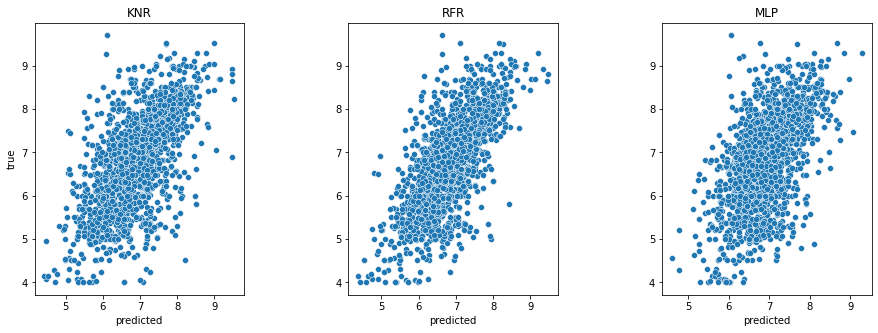

In [32]:
fig, axs = plt.subplots(ncols=3,figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5)

sns.scatterplot(x = y_pred_knr.ravel(), y = y_test.ravel(), ax=axs[0]).set_title('KNR')
sns.scatterplot(x = y_pred_rfr.ravel(), y = y_test.ravel(), ax=axs[1]).set_title('RFR')
sns.scatterplot(x = y_pred_mlp.ravel(), y = y_test.ravel(), ax=axs[2]).set_title('MLP')

axs[0].set(xlabel="predicted", ylabel = "true")
axs[1].set(xlabel="predicted")
axs[2].set(xlabel="predicted")

## Morgan fingerprints

In [13]:
finger = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=1024) for m in df.mol]
df['finger'] = finger

In [14]:
y = np.array(df.value).ravel()
x = np.array(finger)
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

In [38]:
rmse_model = []
std_model = []
for base in bases_all:
    print(base[0])
    cross_model = cross_val_score(base[1], x, y,
                                 scoring='neg_root_mean_squared_error', cv=5)
    print("RMSE: %0.3f, STD: %0.3f" % (-cross_model.mean(), cross_model.std()))
    rmse_model.append(-cross_model.mean())
    std_model.append(cross_model.std())

KNR
RMSE: 0.720, STD: 0.017
RFR
RMSE: 0.674, STD: 0.016
MLP
RMSE: 0.897, STD: 0.016
SVR
RMSE: 0.681, STD: 0.014
LR
RMSE: 0.841, STD: 0.020


In [39]:
model_names = ['KNR', 'RFR', 'MLP', 'SVR', 'LR']
models_finger_score = pd.DataFrame(zip(model_names, rmse_model, std_model),
                                   columns=['MODEL', 'RMSE', 'STD']).sort_values(['RMSE'])
models_finger_score

,MODEL,RMSE,STD
1,RFR,0.673890,0.015509
3,SVR,0.680781,0.013842
0,KNR,0.719663,0.017362
4,LR,0.841032,0.019841
2,MLP,0.897429,0.016257


In [41]:
model_rfr_finger = RFR.fit(X_train, y_train)
model_svr_finger = SVR().fit(X_train, y_train) 
model_knr_finger = KNR.fit(X_train, y_train)

In [42]:
y_pred_knr_finger = model_knr_finger.predict(X_test)
y_pred_rfr_finger = model_rfr_finger.predict(X_test)
y_pred_svr_finger = model_svr_finger.predict(X_test)

[Text(0.5, 0, 'predicted')]

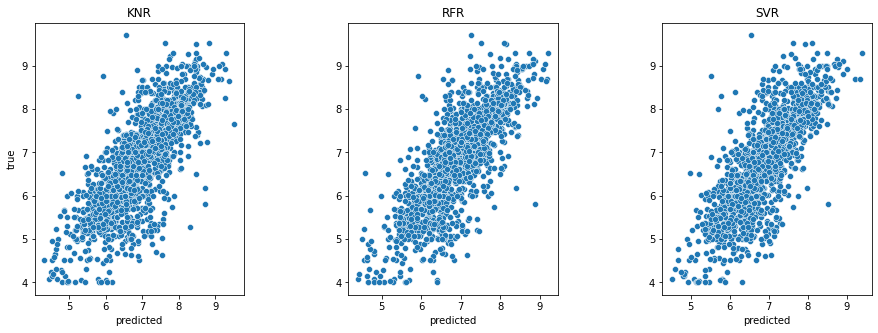

In [43]:
fig, axs = plt.subplots(ncols=3,figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5)

sns.scatterplot(x = y_pred_knr_finger.ravel(), y = y_test.ravel(), ax=axs[0]).set_title('KNR')
sns.scatterplot(x = y_pred_rfr_finger.ravel(), y = y_test.ravel(), ax=axs[1]).set_title('RFR')
sns.scatterplot(x = y_pred_svr_finger.ravel(), y = y_test.ravel(), ax=axs[2]).set_title('SVR')

axs[0].set(xlabel="predicted", ylabel = "true")
axs[1].set(xlabel="predicted")
axs[2].set(xlabel="predicted")

Modely si vedou lépe na morganových fingerprintech. Nejvhodnějšími modely jsou RFR, SVR a KNR. Těmto modelům optimalizuji paramtery, abych našla ten nejlepší. Optimalizuji parametry také MLP, jelikož predikce tohoto modelu se po optimalizaci může rapidně zlepšit.

## Optimalizace parametrů 

In [47]:
#KNR
params = {'n_neighbors' : [10, 15, 20], 
          'weights': ['uniform', 'distance'], 
          'p':[1,2],
          'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
search = GridSearchCV(KNR, params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
results_KNR = search.fit(x, y)
print('Best RMSE: %0.3f' % -results_KNR.best_score_)
print('Best Hyperparameters: %s' % results_KNR.best_params_)

Best RMSE: 0.705
Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


In [49]:
#RFR
params = { 'max_depth': [8, 15, 20, 30, 40, None],
           'max_features': ['auto', 'sqrt'],
           'n_estimators': [50, 100, 200]}
search = GridSearchCV(RFR, params,scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
results_RFR = search.fit(x, y)
print('Best RMSE: %0.3f' % -results_RFR.best_score_)
print('Best Hyperparameters: %s' % results_RFR.best_params_)

Best RMSE: 0.672
Best Hyperparameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}


In [48]:
#SVR
params = {'kernel': ['poly', 'rbf'], 
          'shrinking': [True, False]}
search = GridSearchCV(SV, params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
results_SVR = search.fit(x, y)
print('Best RMSE: %0.3f' % -results_SVR.best_score_)
print('Best Hyperparameters: %s' % results_SVR.best_params_)

Best RMSE: 0.665
Best Hyperparameters: {'kernel': 'poly', 'shrinking': True}


In [52]:
neurons = (1200, 500)
layers = []
for i in range(1,4):
    layers = layers +[x for x in itertools.product(neurons,repeat=i)]

In [53]:
#MLP
params = {'hidden_layer_sizes': layers}
search = GridSearchCV(MLP, params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
results_MLP = search.fit(x, y)
print('Best Score: %s' % -results_MLP.best_score_)
print('Best STD: %0.3f' % np.mean(results_MLP.cv_results_['std_test_score']))
print('Best Hyperparameters: %s' % results_MLP.best_params_)

Best Score: 0.6765622661971296
Best STD: 0.014
Best Hyperparameters: {'hidden_layer_sizes': (1200, 500, 500)}


In [54]:
model_rmse_all = [-results_KNR.best_score_, -results_RFR.best_score_,
                  -results_MLP.best_score_, -results_SVR.best_score_]
model_names = ['KNR','RFR', 'MLP','SVR']
RMSE_models = pd.DataFrame(zip(model_names, model_rmse_all), columns=['MODEL', 'RMSE']).sort_values(['RMSE'])
RMSE_models

,MODEL,RMSE
3,SVR,0.664941
1,RFR,0.672234
2,MLP,0.676562
0,KNR,0.705360


Nejlepší model je SVR s paramtery {'kernel': 'poly', 'shrinking': True}. Tento model použiji pro predikci aktivity u DrugBank. Je zajímavé si povšimnout, jak se predikce MLP výrazně optimalizací zlepšila. 

# DrugBank

In [8]:
drug = Chem.SDMolSupplier('drugbank.sdf')
ids=[]
for i in range(len(drug)):
    if drug[i] is not None:
        ids.append(drug[i].GetProp('DATABASE_ID')) 
        
inchi=[]
for i in range(len(drug)):
    if drug[i] is not None:
        inchi.append(drug[i].GetProp('INCHI_IDENTIFIER')) 
        
data = {'id': ids,
        'inchi': inchi}
drug_df = pd.DataFrame(data, columns = ['id', 'inchi'])

In [9]:
drug_df['mol'] = [Chem.inchi.MolFromInchi(i) for i in drug_df['inchi']]
drug_df = drug_df.dropna()
drug_finger = [Chem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in drug_df.mol]
drug_df['finger'] = drug_finger

In [15]:
model_svr = SVR(kernel='poly', shrinking=True).fit(x, y)

In [16]:
y_pred_svr = model_svr.predict(np.array(drug_finger))

VEGF datset obsahuje 6715 záznamů. Pomocí aktivitního tresholdu se struktury dělí na 1972 aktivních a 4743 neaktivních na VEGF receptoru. Z toho vyplývá, že je 29,44% VEGF datasetu aktivní.

In [17]:
treshold = 7.523
df['activity']='inactive'
df.loc[df['value'] > treshold, 'activity'] = 'active'

In [18]:
df['activity'].value_counts()

inactive    4725
active      1971
Name: activity, dtype: int64

In [19]:
prob = len(df.loc[df['activity'] == 'active'])/len(df)*100
print("Aktivních procent %0.2f" % prob, end ='% ')

Aktivních procent 29.44% 

DrugBank datset obsahuje 7112 záznamů. Hodnoty pI50 jsem predikovala pomocí SVR modelu. Pomocí aktivitního tresholdu se struktury dělí na 11 aktivních a 7101 neaktivních na VEGF receptoru. To znamená, že je aktivních pouze 0.15% datasetu. 

In [20]:
drug_df['value'] = y_pred_svr

In [21]:
drug_df['activity']='inactive'
drug_df.loc[drug_df['value'] > treshold, 'activity'] = 'active'

In [22]:
drug_df['activity'].value_counts()

inactive    7101
active        11
Name: activity, dtype: int64

In [22]:
prob = len(drug_df.loc[drug_df['activity'] == 'active'])/len(drug_df)*100
print("Aktivních procent %0.4f" % prob, end ='% ')

Aktivních procent 0.1547% 

Na následujících obrázcích je vidět porovnání distribucí value (pIC50) hodnot pro VEGF dataset a pro DrugBank.

Text(0.5, 1.0, 'VEGF')

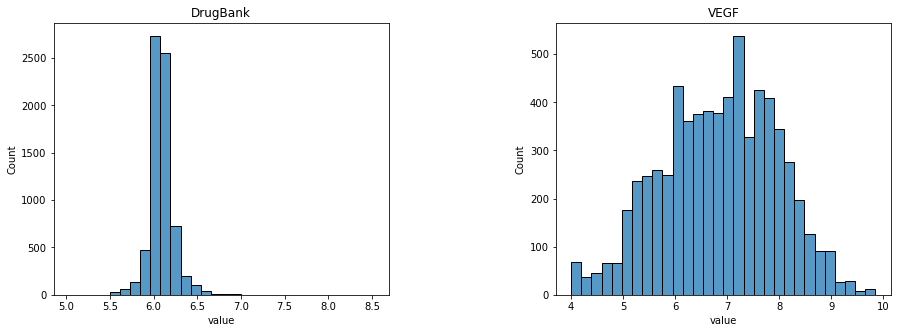

In [25]:
fig, axs = plt.subplots(ncols=2,figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5)

sns.histplot(data=drug_df, x="value", bins=30, ax=axs[0]).set_title('DrugBank')
sns.histplot(data=df, x="value", bins=30, ax=axs[1]).set_title('VEGF')

Text(0.5, 1.0, 'VEGF')

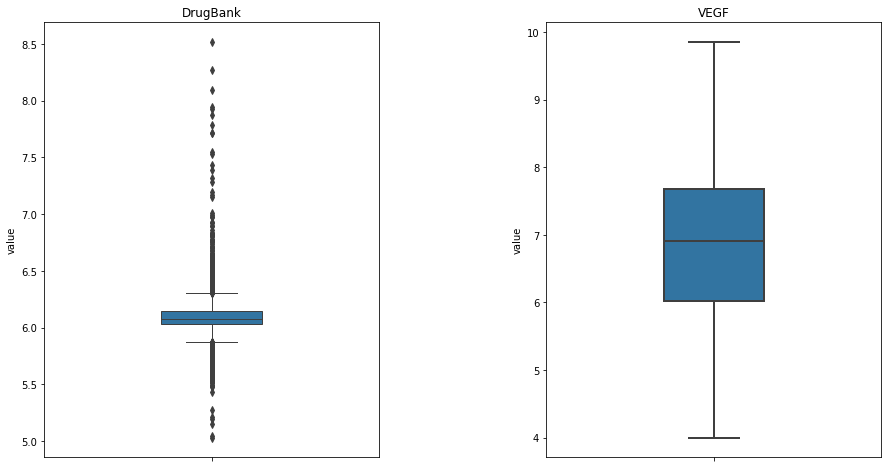

In [52]:
fig, axs = plt.subplots(ncols=2,figsize=(15, 8))
plt.subplots_adjust(wspace = 0.5)

sns.boxplot(y='value', data=drug_df, width=0.3, linewidth=1, ax=axs[0]).set_title('DrugBank')
sns.boxplot(y='value', data=df, width=0.3, linewidth=2, ax=axs[1]).set_title('VEGF')

# Vizualizace 

Následují vizualizace chemického prostoru pomocí metod PCA a MDS. Jsou zde vizualizovány jednotlivé datasety a barevně jsou odlišeny aktivní a neaktivní látky.

In [35]:
colors2 =['#7BDDFF','gray'] 
colors = {'active':'#7BDDFF','inactive':'gray'}

pca = PCA(0.9) # 90% of explained variance

In [34]:
pca.fit(finger)
PCA_finger = pca.transform(finger)

pca.fit(drug_finger)
PCA_drug_finger = pca.transform(drug_finger)

Text(0.5, 1.0, 'PCA DrugBank')

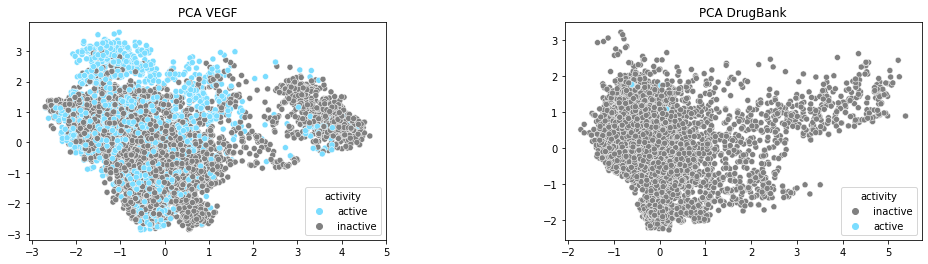

In [36]:
fig, axs = plt.subplots(ncols=2,figsize=(16, 4))
plt.subplots_adjust(wspace = 0.5)

sns.scatterplot(x=PCA_finger[:,0], y=PCA_finger[:,1], hue=df['activity'],palette=colors, ax=axs[0]).set_title('PCA VEGF')
sns.scatterplot(x=PCA_drug_finger[:,0], y=PCA_drug_finger[:,1], hue=drug_df['activity'],
                       palette=colors, ax=axs[1]).set_title('PCA DrugBank')

Není patrná žádná významná separace aktivních a neaktivních shluků. Nicméně aktivní látky DrugBank se drží relativně blízko u sebe.

Dále jsou datasety sloučeny a vizualizovány společně. Barevně jsou odlišeny aktivní a neaktivní látky a vedle pro srovnání jsou odlišeny látky z VEGF a DrugBank. 

In [38]:
ids = np.concatenate((np.array(drug_df.id), np.array(df.cmpd_chembl_id)))
value = np.concatenate((np.array(drug_df.value), np.array(df.value)))
activity = np.concatenate((np.array(drug_df.activity), np.array(df.activity)))
source = ['DrugBank' for i in range(len(drug_df))] + ['VEGF' for i in range(len(df))]
fingers = drug_finger + finger
mols =  [Chem.inchi.MolFromInchi(i) for i in drug_df['inchi']] + [Chem.MolFromSmiles(i) for i in df['canonical_smiles']]

data = {'id': ids,
        'value': value,
        'activity': activity,
        'source':source,
        'finger':fingers,
        'mol':mols
       }
df_all = pd.DataFrame(data, columns = ['id', 'value', 'activity', 'source','finger','mol'])

In [39]:
pca.fit(fingers)
PCA_all = pca.transform(fingers)

Text(0.5, 1.0, 'PCA source')

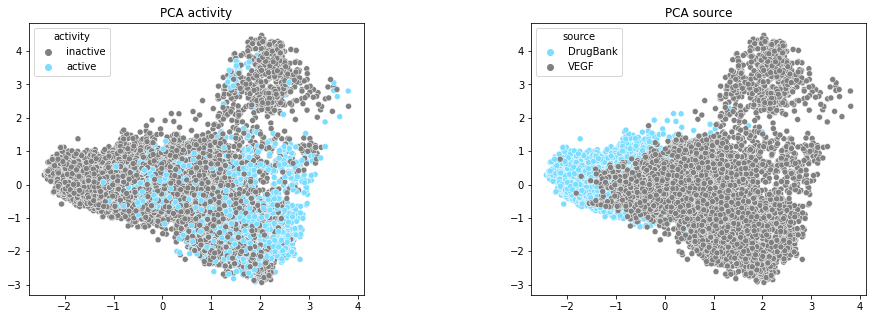

In [40]:
fig, axs = plt.subplots(ncols=2,figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5)

sns.scatterplot(x=PCA_all[:,0], y=PCA_all[:,1], hue=df_all['activity'],palette=colors,ax=axs[0]).set_title('PCA activity')
sns.scatterplot(x=PCA_all[:,0], y=PCA_all[:,1], hue=df_all['source'],palette=colors2,ax=axs[1]).set_title('PCA source')

Opět není patrná významná separace shluků, ale možná je vidět slabá tendence aktivních látek vpravo a neaktivnách vlevo. Vlevo je vidět větší množství neaktivních látek a podle druhého obrázku vidíme, že v těchto místech převládá DrugBank. Obdobně vpravo pro aktivní, převládá VEGF dataset.

In [25]:
#sparse = distance.pdist(fingers, metric="jaccard")
#distance = distance.squareform(sparse)
#clf = MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
#fps_mds = clf.fit_transform(distance)

In [28]:
fps_mds = pd.read_csv('MDS.txt', sep=' ')

Na vizualizaci pomocí MDS je vidět separace DrugBank a VEGF dat. Po obvodu shluku, kde se vyskytují DrugBank data je vidět, že se nachází neaktivní ligandy.

Text(0.5, 1.0, 'MDS source')

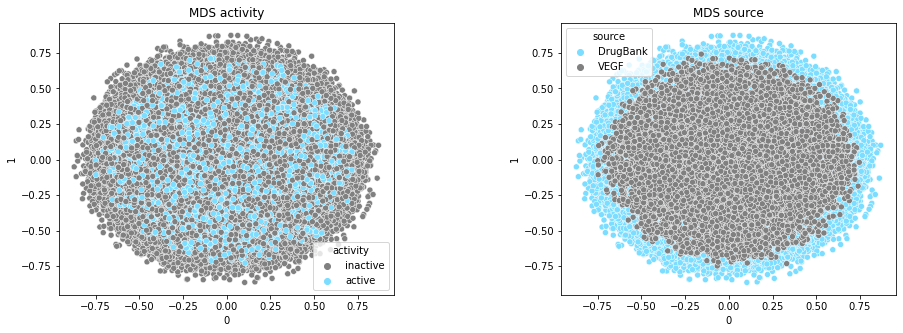

In [41]:
fig, axs = plt.subplots(ncols=2,figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5)

sns.scatterplot(x=fps_mds['0'], y=fps_mds['1'], hue=df_all['activity'], palette=colors,ax=axs[0]).set_title('MDS activity')
sns.scatterplot(x=fps_mds['0'], y=fps_mds['1'], hue=df_all['source'], palette=colors2,ax=axs[1]).set_title('MDS source')

# Sccafolds

In [94]:
from rdkit.Chem.Scaffolds import MurckoScaffold
from IPython.core.display import HTML
from rdkit.Chem.Draw import rdMolDraw2D
from io import BytesIO
import base64

In [88]:
def mol2display_png(mol):
    """Format RDKit mol for direct inline display. The most convenient, probably."""
    d2d = rdMolDraw2D.MolDraw2DCairo(400,400)
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    buffer = BytesIO(d2d.GetDrawingText())
    return f'<img src="data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}">'

In [84]:
df_all["scaffold1"] = df_all['mol'].apply(MurckoScaffold.GetScaffoldForMol)
df_all["scaffold2"] = df_all['scaffold1'].apply(MurckoScaffold.MakeScaffoldGeneric)
df_all["scaffold3"] = df_all['scaffold2'].apply(MurckoScaffold.GetScaffoldForMol)

### Aktivní DrugBank

Nejprve se podívám na scaffoldy u aktivních DrugBank.

In [184]:
drug = df_all.loc[df_all['source'] == 'DrugBank']
active_drug = drug.loc[drug['activity'] == 'active']
active_drug = active_drug.sort_values(by=['value'], ascending=False)

,mol,scaffold3,value
6677,,,8.513963
4316,,,8.270829
5145,,,8.089933
6662,,,7.942728
6419,,,7.927822
4591,,,7.873543
4898,,,7.783411
4447,,,7.712600
6582,,,7.712600
5885,,,7.542354

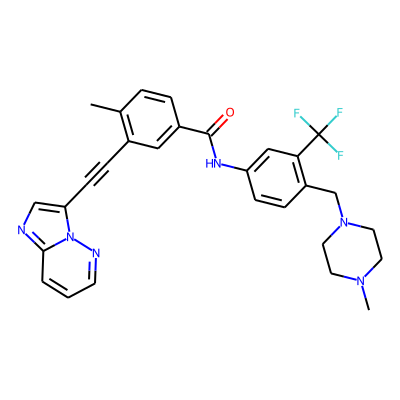
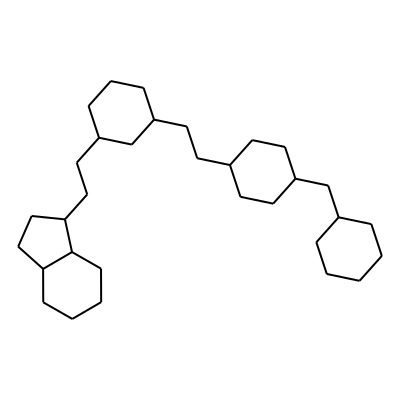
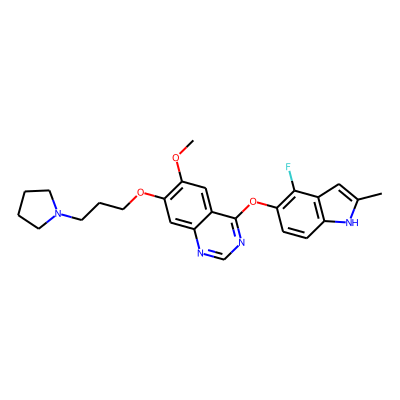
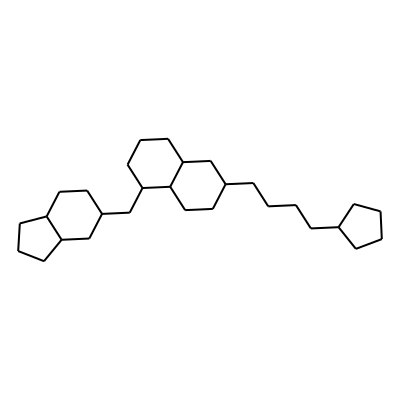
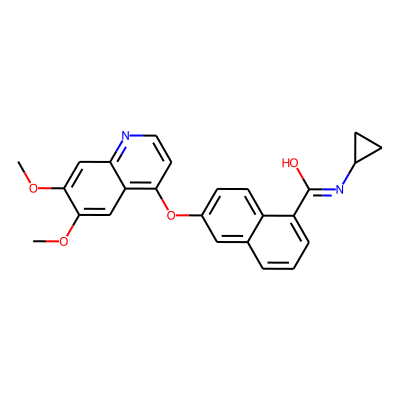
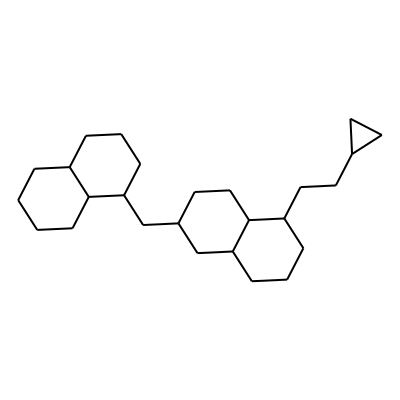
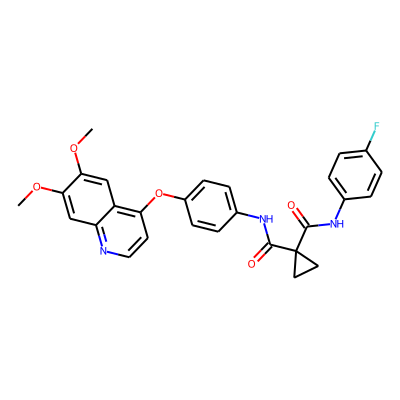
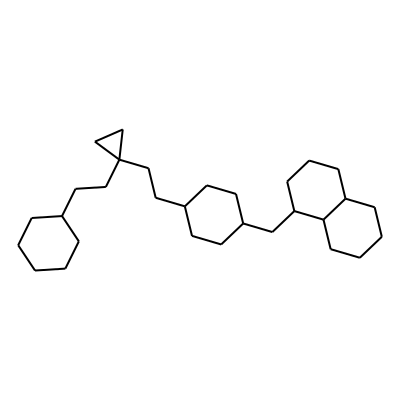
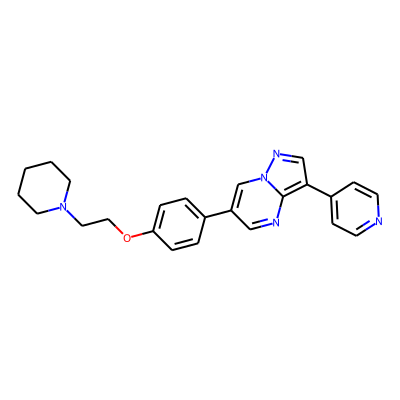
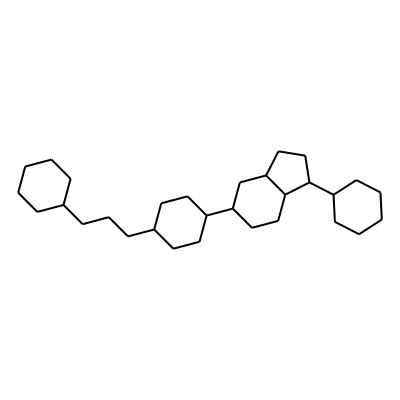
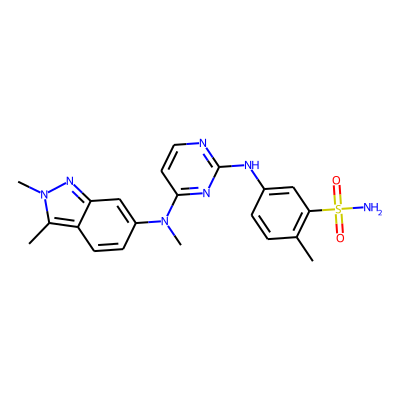
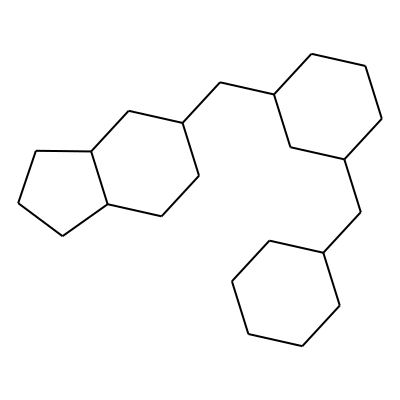
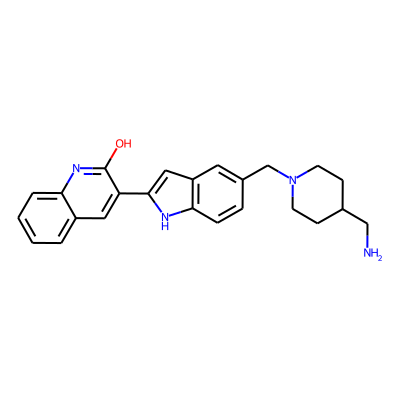
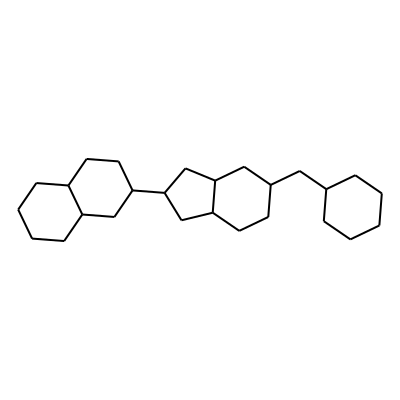
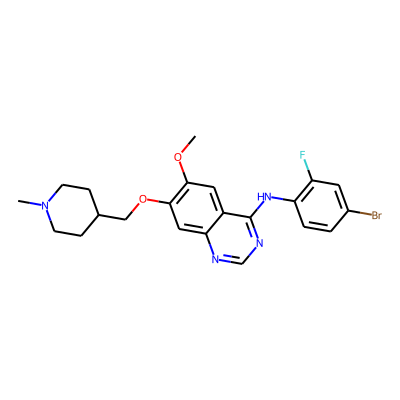
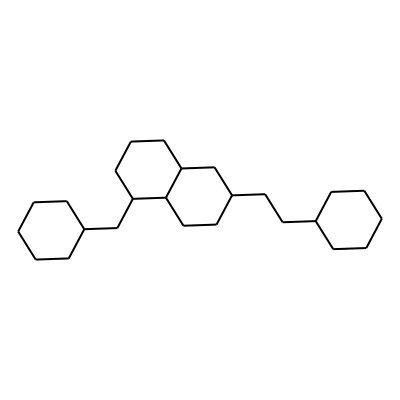
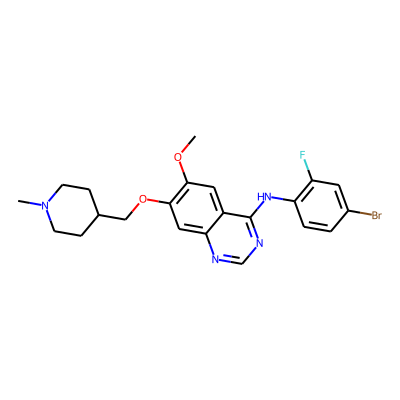
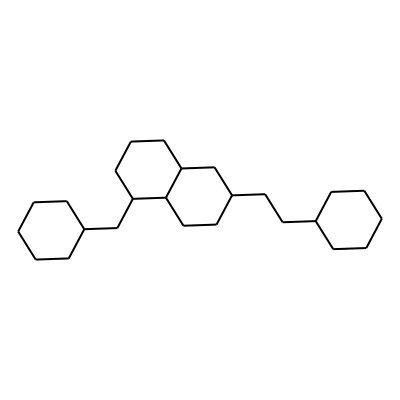
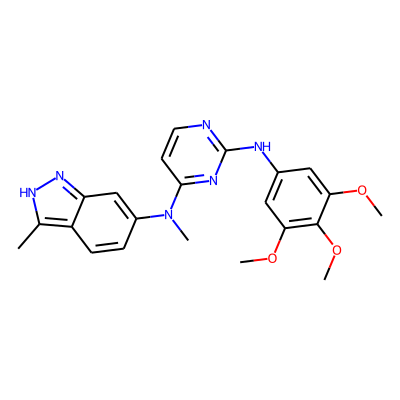
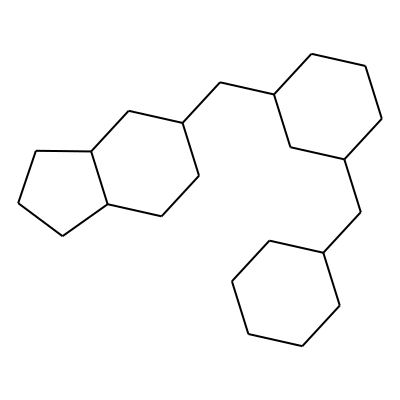
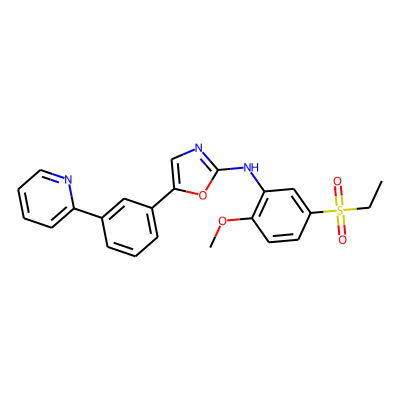
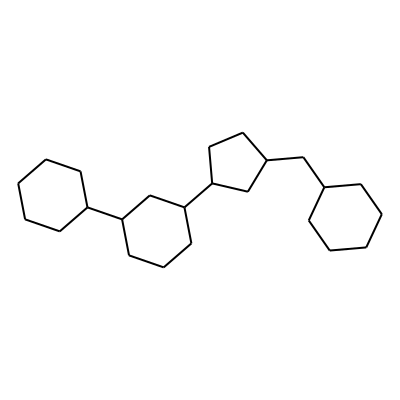

In [185]:
HTML(active_drug[['mol','scaffold3','value']].to_html(
    formatters={'mol': mol2display_png, 'scaffold3': mol2display_png}, escape=False))

Mohlo by nás zajímat, jestli se některé scaffoldy vyskytují opakovaně. Dva scaffoldy se v 11 aktivních strukturách vyskytují dvakrát. 

In [186]:
active_drug["scaffold3_smiles"] = active_drug['scaffold3'].apply(Chem.MolToSmiles)

In [187]:
scaff_drug_active = active_drug['scaffold3_smiles'].value_counts()
scaff_drug_active_df = pd.DataFrame(scaff_drug_active)
scaff_drug_active_df['scaffold'] = scaff_drug_active_df.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))
scaff_drug_active_df.reset_index(inplace=True)
scaff_drug_active_df = scaff_drug_active_df.rename(columns={"scaffold3_smiles": "count"})
scaff_drug_active_df

,index,count,scaffold
0,C1CCC(CC2CCCC(CC3CCC4CCCC4C3)C2)CC1,2,<rdkit.Chem.rdchem.Mol object at 0x00000154120...
1,C1CCC(CCC2CCC3C(CC4CCCCC4)CCCC3C2)CC1,2,<rdkit.Chem.rdchem.Mol object at 0x00000154120...
2,C1CCC(CC2CCC(CCC3CCCC(CCC4CCC5CCCCC54)C3)CC2)CC1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154120...
3,C1CCC(CCCCC2CCC3C(CCCC3CC3CCC4CCCC4C3)C2)C1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154120...
4,C1CCC2C(C1)CCCC2CC1CCC2C(CCC3CC3)CCCC2C1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154120...
5,C1CCC(CCC2(CCC3CCC(CC4CCCC5CCCCC54)CC3)CC2)CC1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154120...
6,C1CCC(CCCC2CCC(C3CCC4C(CCC4C4CCCCC4)C3)CC2)CC1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154120...
7,C1CCC(CC2CCC3CC(C4CCC5CCCCC5C4)CC3C2)CC1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154120...
8,C1CCC(CC2CCC(C3CCCC(C4CCCCC4)C3)C2)CC1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154120...


Pravděpodobnost v procentech, že aktivních ligand z DrugBank má daný scaffold.

In [188]:
scaff_drug_active_df["probability"] = scaff_drug_active_df["count"].apply(lambda x: float(x)/len(active_drug)*100)
scaff_drug_active_df.head()

,index,count,scaffold,probability
0,C1CCC(CC2CCCC(CC3CCC4CCCC4C3)C2)CC1,2,<rdkit.Chem.rdchem.Mol object at 0x00000154120...,18.181818
1,C1CCC(CCC2CCC3C(CC4CCCCC4)CCCC3C2)CC1,2,<rdkit.Chem.rdchem.Mol object at 0x00000154120...,18.181818
2,C1CCC(CC2CCC(CCC3CCCC(CCC4CCC5CCCCC54)C3)CC2)CC1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154120...,9.090909
3,C1CCC(CCCCC2CCC3C(CCCC3CC3CCC4CCCC4C3)C2)C1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154120...,9.090909
4,C1CCC2C(C1)CCCC2CC1CCC2C(CCC3CC3)CCCC2C1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154120...,9.090909


,index,count,scaffold,probability
0,C1CCC(CC2CCCC(CC3CCC4CCCC4C3)C2)CC1,2,,18.181818
1,C1CCC(CCC2CCC3C(CC4CCCCC4)CCCC3C2)CC1,2,,18.181818

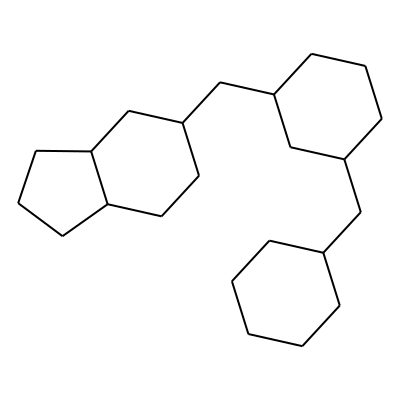
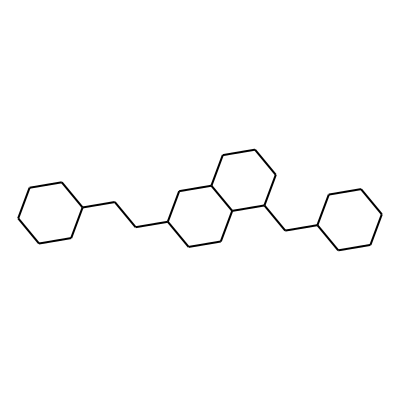

In [189]:
HTML(scaff_drug_active_df.loc[scaff_drug_active_df['count']  > 1].to_html(
    formatters={'scaffold': mol2display_png}, escape=False))

V celém zbytku DrugBank datasetu je jen 1 neaktivní látka se stejným scaffoldem jako mají aktivní DrugBank.

In [195]:
drug["scaffold3_smiles"] = drug['scaffold3'].apply(Chem.MolToSmiles)
numbers = []
for k in range(len(scaff_drug_active_df)):
    s = 0
    for i in range(len(drug)):
        s = s + (drug.scaffold3_smiles[i] == scaff_drug_active_df['index'][k])
    numbers.append(s)

In [196]:
scaff_drug_active_df['number in DrugBank'] = numbers

In [197]:
scaff_drug_active_df

,index,count,scaffold,probability,number in DrugBank
0,C1CCC(CC2CCCC(CC3CCC4CCCC4C3)C2)CC1,2,<rdkit.Chem.rdchem.Mol object at 0x00000154120...,18.181818,3
1,C1CCC(CCC2CCC3C(CC4CCCCC4)CCCC3C2)CC1,2,<rdkit.Chem.rdchem.Mol object at 0x00000154120...,18.181818,2
2,C1CCC(CC2CCC(CCC3CCCC(CCC4CCC5CCCCC54)C3)CC2)CC1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154120...,9.090909,1
3,C1CCC(CCCCC2CCC3C(CCCC3CC3CCC4CCCC4C3)C2)C1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154120...,9.090909,1
4,C1CCC2C(C1)CCCC2CC1CCC2C(CCC3CC3)CCCC2C1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154120...,9.090909,1
5,C1CCC(CCC2(CCC3CCC(CC4CCCC5CCCCC54)CC3)CC2)CC1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154120...,9.090909,1
6,C1CCC(CCCC2CCC(C3CCC4C(CCC4C4CCCCC4)C3)CC2)CC1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154120...,9.090909,1
7,C1CCC(CC2CCC3CC(C4CCC5CCCCC5C4)CC3C2)CC1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154120...,9.090909,1
8,C1CCC(CC2CCC(C3CCCC(C4CCCCC4)C3)C2)CC1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154120...,9.090909,1


### Aktivní VEGF

Můžeme se jěště podívat na scaffoldy u aktivních VEGF. 

In [198]:
vegf = df_all.loc[df_all['source'] == 'VEGF']
active_vegf = vegf.loc[vegf['activity'] == 'active']
active_vegf = active_vegf.sort_values(by=['value'], ascending=False)

,mol,scaffold3,value
9593,,,9.85
9591,,,9.82
13720,,,9.70

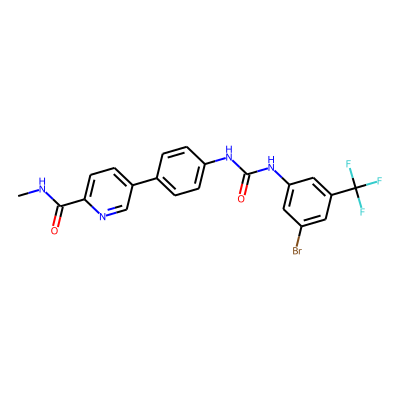
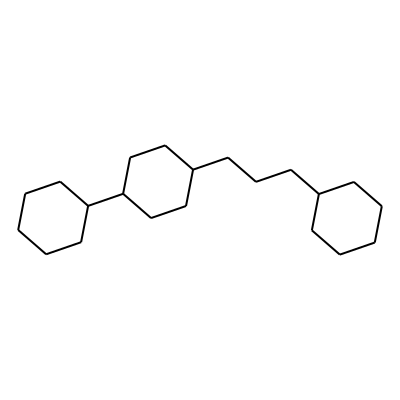
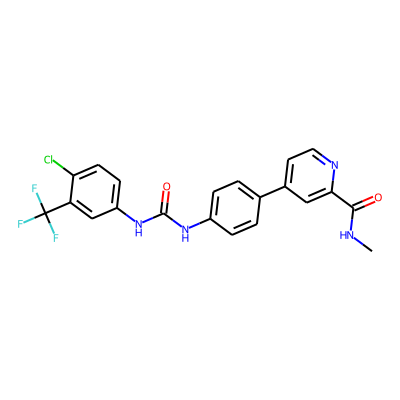
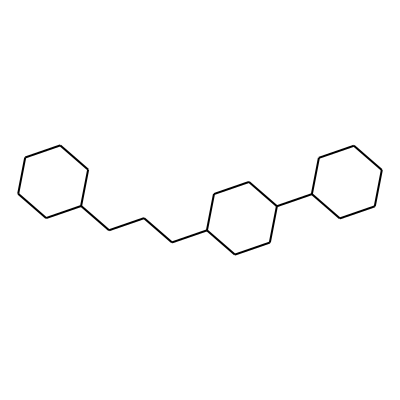
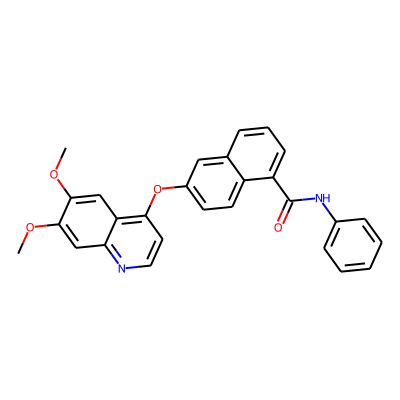
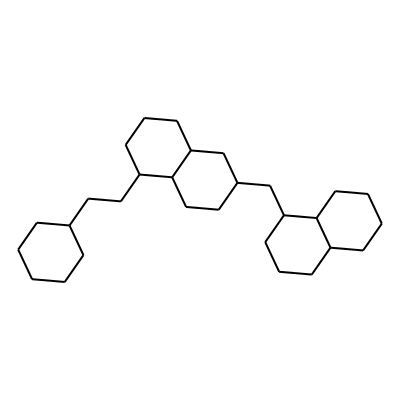

In [199]:
HTML(active_vegf[['mol','scaffold3','value']].head(3).to_html(
    formatters={'mol': mol2display_png, 'scaffold3': mol2display_png}, escape=False))

Je zde 1971 aktivních struktur. Nejčastější scaffold je zde 156 krát.

In [200]:
active_vegf["scaffold3_smiles"] = active_vegf['scaffold3'].apply(Chem.MolToSmiles)

In [201]:
scaff_vegf_active = active_vegf['scaffold3_smiles'].value_counts()
scaff_vegf_active_df = pd.DataFrame(scaff_vegf_active)
scaff_vegf_active_df['scaffold'] = scaff_vegf_active_df.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))
scaff_vegf_active_df.reset_index(inplace=True)
scaff_vegf_active_df = scaff_vegf_active_df.rename(columns={"scaffold3_smiles": "count"})
scaff_vegf_active_df.head()

,index,count,scaffold
0,C1CCC(CCCC2CCC(CC3CCCC(CCC4CC4)C3)CC2)CC1,156,<rdkit.Chem.rdchem.Mol object at 0x00000154120...
1,C1CCC(CCCC2CCC(C3CCCC4CCCC43)CC2)CC1,66,<rdkit.Chem.rdchem.Mol object at 0x00000154120...
2,C1CCC(CCCC2CCC(CC3CCCC(C4CCCC4)C3)CC2)CC1,53,<rdkit.Chem.rdchem.Mol object at 0x00000154146...
3,C1CCC(CCC2CCCC3CC(CC4CCCC5CCCCC54)CCC23)CC1,48,<rdkit.Chem.rdchem.Mol object at 0x00000154146...
4,C1CCC(CCCC2CCC(CC3CCCC4CCCC43)CC2)CC1,46,<rdkit.Chem.rdchem.Mol object at 0x00000154146...


Pravděpodobnost v procentech, že aktivní ligand z VEGF má daný scaffold.

In [202]:
scaff_vegf_active_df["probability"] = scaff_vegf_active_df["count"].apply(lambda x: float(x)/len(active_vegf)*100)
scaff_vegf_active_df.head()

,index,count,scaffold,probability
0,C1CCC(CCCC2CCC(CC3CCCC(CCC4CC4)C3)CC2)CC1,156,<rdkit.Chem.rdchem.Mol object at 0x00000154120...,7.914764
1,C1CCC(CCCC2CCC(C3CCCC4CCCC43)CC2)CC1,66,<rdkit.Chem.rdchem.Mol object at 0x00000154120...,3.348554
2,C1CCC(CCCC2CCC(CC3CCCC(C4CCCC4)C3)CC2)CC1,53,<rdkit.Chem.rdchem.Mol object at 0x00000154146...,2.688990
3,C1CCC(CCC2CCCC3CC(CC4CCCC5CCCCC54)CCC23)CC1,48,<rdkit.Chem.rdchem.Mol object at 0x00000154146...,2.435312
4,C1CCC(CCCC2CCC(CC3CCCC4CCCC43)CC2)CC1,46,<rdkit.Chem.rdchem.Mol object at 0x00000154146...,2.333841


,index,count,scaffold,probability
0,C1CCC(CCCC2CCC(CC3CCCC(CCC4CC4)C3)CC2)CC1,156,,7.914764
1,C1CCC(CCCC2CCC(C3CCCC4CCCC43)CC2)CC1,66,,3.348554
2,C1CCC(CCCC2CCC(CC3CCCC(C4CCCC4)C3)CC2)CC1,53,,2.688990
3,C1CCC(CCC2CCCC3CC(CC4CCCC5CCCCC54)CCC23)CC1,48,,2.435312
4,C1CCC(CCCC2CCC(CC3CCCC4CCCC43)CC2)CC1,46,,2.333841

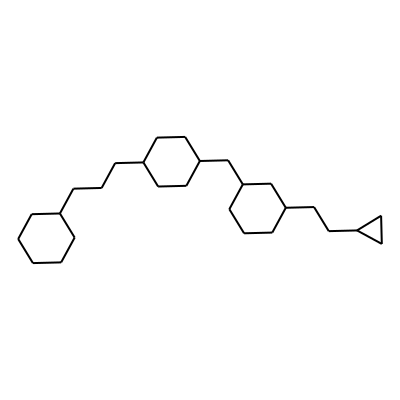
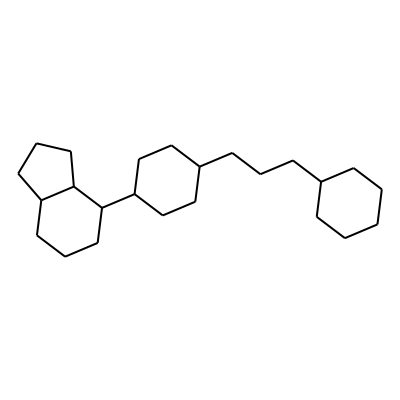
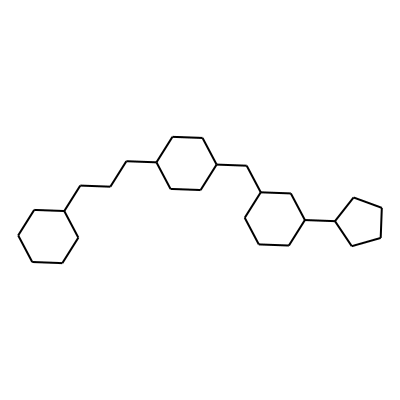
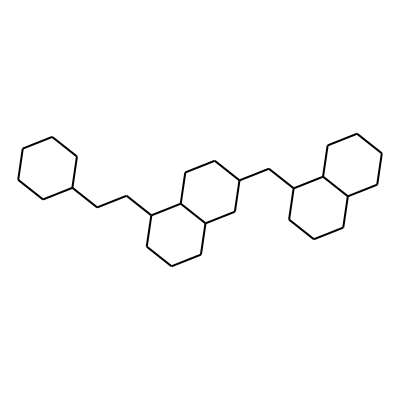
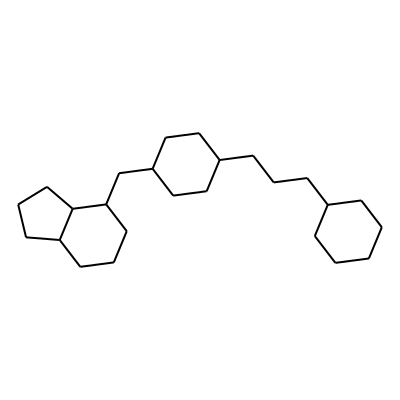

In [203]:
HTML(scaff_vegf_active_df.head().to_html(formatters={'scaffold': mol2display_png}, escape=False))

### Aktivní VEGF vs. DrugBank

Porovnání scaffoldů aktivních ligandů v VEGF a DrugBank. Každý ze scaffoldů aktivních DrugBank se vyskytuje mezi scafoldy aktivních VEGF.

In [204]:
numbers = []
for k in range(len(scaff_drug_active_df)):
    s = 0
    for i in range(len(scaff_vegf_active_df)):
        s = s + (scaff_vegf_active_df['index'][i] == scaff_drug_active_df['index'][k])
    numbers.append(s)

In [205]:
numbers

[1, 1, 1, 1, 1, 1, 1, 1, 1]

Nicméně scaffoldy aktivních DrugBank nejsou mezi scafoldy aktivních VEGF moc zastoupeny. Pouze 2.59% aktivních VEGF má stejný skaffold s aktivními DrugBank.

In [206]:
numbers = []
for k in range(len(scaff_vegf_active_df)):
    s = 0
    for i in range(len(scaff_drug_active_df)):
        s = s + (scaff_vegf_active_df['index'][k] == scaff_drug_active_df['index'][i])
    numbers.append(s)

In [207]:
scaff_vegf_active_df['activity_DrugBank']=numbers

In [208]:
cut = scaff_vegf_active_df.loc[scaff_vegf_active_df['activity_DrugBank'] == 1]
cut

,index,count,scaffold,probability,activity_DrugBank
36,C1CCC(CC2CCCC(CC3CCC4CCCC4C3)C2)CC1,11,<rdkit.Chem.rdchem.Mol object at 0x00000154146...,0.558092,1
37,C1CCC(CCC2CCC3C(CC4CCCCC4)CCCC3C2)CC1,11,<rdkit.Chem.rdchem.Mol object at 0x00000154146...,0.558092,1
39,C1CCC(CCCC2CCC(C3CCC4C(CCC4C4CCCCC4)C3)CC2)CC1,10,<rdkit.Chem.rdchem.Mol object at 0x00000154146...,0.507357,1
52,C1CCC(CC2CCC3CC(C4CCC5CCCCC5C4)CC3C2)CC1,8,<rdkit.Chem.rdchem.Mol object at 0x00000154146...,0.405885,1
70,C1CCC2C(C1)CCCC2CC1CCC2C(CCC3CC3)CCCC2C1,6,<rdkit.Chem.rdchem.Mol object at 0x00000154146...,0.304414,1
224,C1CCC(CC2CCC(C3CCCC(C4CCCCC4)C3)C2)CC1,2,<rdkit.Chem.rdchem.Mol object at 0x00000154146...,0.101471,1
372,C1CCC(CCCCC2CCC3C(CCCC3CC3CCC4CCCC4C3)C2)C1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154146...,0.050736,1
400,C1CCC(CC2CCC(CCC3CCCC(CCC4CCC5CCCCC54)C3)CC2)CC1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154146...,0.050736,1
441,C1CCC(CCC2(CCC3CCC(CC4CCCC5CCCCC54)CC3)CC2)CC1,1,<rdkit.Chem.rdchem.Mol object at 0x00000154146...,0.050736,1


In [209]:
p = cut['count'].sum()/len(active_vegf)*100
print("Stejné scaffoldy %0.2f" % p, end='%')

Stejné scaffoldy 2.59%